In [1]:
# In this file I have created the final data that will be used by the model:
# In the following lines you will see how I:
# Found and cleaned data for:
#         1.1 Population distribution for the different counties trend (between 90s and 2000s) 
#         1.2 Trend of unemployement rates for the different counties (between 1996 and 2001)
#         1.3 Trend of housing permits for the different counties (between 1999 and 2001)
#         2 Insert county values into shapefile
#         3. Location of walmarts based on year and type of store (supercenter or normal walmart store) 

In [2]:
# Since the values for population distribution, unemployement rates and housing permits are given for each county, and 
# unfortunately not at specific location, they will all belong to the same dataframe that I will then shape thanks to the shape
# file
"""
PART: 1.1 - Starting of with the Population Density
"""

'\nPART: 1.1 - Starting of with the Population Density\n'

In [3]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt

In [4]:
# I found a link that presents in tabular data the population for each county in the Censuns of 1990,2000,2010 and so on
wisconsin = pd.read_html('http://citypopulation.de/en/usa/admin/WI__wisconsin/')
population_data = wisconsin[0]
# cleaning the data, only interested in knowing the values for the year 1990 and 2000
population_data = population_data.drop(columns=['PopulationCensus2010-04-01','PopulationEstimate2019-07-01','Unnamed: 6'])
# change column names
population_data.columns = ['Name','Status','Population_1990','Population_2000']
# also a value for the whole state is presented, which we are not going to need
population_data = population_data[population_data['Status']=='County']
population_data.drop(columns=['Status'], inplace=True)
# We are left with this dataframe
print(population_data.head())
print(population_data.shape)

       Name  Population_1990  Population_2000
1     Adams            15682            19940
2   Ashland            16307            16845
3    Barron            40750            44961
4  Bayfield            14008            15027
5     Brown           194594           226633
(72, 3)


In [5]:
# Note the number of counties == 72, it will serve in the future for check-in
# I'm making sure that the counties names do not have any white spacing, which would cause a mess when merging
population_data["Name"] = population_data["Name"].str.title()
population_data["Name"] = population_data["Name"].str.strip()
# Not really interested in the singular value, but more on the trend of the past years, i.e. which counties 
# showed an increase in population and which didn't
# the value is presented in percentage
population_data['delta_population'] = (population_data['Population_2000']/population_data['Population_1990'] -1)*100

In [6]:
"""
PART: 1.2 - Employment and unemployement data for each county
"""

'\nPART: 1.2 - Employment and unemployement data for each county\n'

In [7]:
# in this case, the data was derived from the following two links, I opted to use 5 years as a time interval,
# with more time, one could find a trend with all values and the use the derivative at 2001
# links are the following:
link1996 = 'https://www.bls.gov/lau/laucnty96.txt'
link2001 = 'https://www.bls.gov/lau/laucnty01.txt'

# manipolation of data: 
data1996 = pd.read_csv(link1996,sep='\s\s+',skiprows=6,header=None, error_bad_lines=False, warn_bad_lines=False)
#name the columns
data1996.columns = ['LAUS','State_Code','County_Code','County','Year','Labor_force','Employed','Unemployed','Un_rate']
#find values only for Wisconsin, which has a state code of 55
data1996 = data1996[data1996['State_Code']=='55']
data1996.drop(columns=['LAUS','State_Code','Year','County_Code','Labor_force'], inplace = True)
#cleaning up the date
data1996.replace('County, WI','', regex=True, inplace=True)
data1996.replace(',','',regex=True, inplace=True)
for col in data1996.columns:
    if col != 'County':
        data1996[col] = data1996[col].apply(lambda x: float(x)) 

# same for 2201
data2001 = pd.read_csv(link2001,sep='\s\s+',skiprows=6,header=None, error_bad_lines=False, warn_bad_lines=False)
data2001.columns = ['LAUS','State_Code','County_Code','County','Year','Labor_force','Employed','Unemployed','Un_rate']
data2001 = data2001[data2001['State_Code']=='55']
data2001.drop(columns=['LAUS','State_Code','Year','County_Code','Labor_force'], inplace = True)
data2001.replace('County, WI','', regex=True, inplace=True)
data2001.replace(',','',regex=True, inplace=True)
for col in data2001.columns:
    if col != 'County':
        data2001[col] = data2001[col].apply(lambda x: float(x)) 
        
# create a final dataframe, that contains for each county the variation of total number of employed, unemployed and the unemployement rate
employement_data = pd.DataFrame()
employement_data['County'] = data2001['County']
employement_data['delta_employed'] = (data2001['Employed']/data1996['Employed'] - 1)*100
employement_data['delta_unemployed'] = (data2001['Unemployed']/data1996['Unemployed'] - 1)*100
employement_data['delta_rate'] = (data2001['Un_rate']/data1996['Un_rate'] - 1)*100

<ipython-input-7-f6a07be7c205>:8: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  data1996 = pd.read_csv(link1996,sep='\s\s+',skiprows=6,header=None, error_bad_lines=False, warn_bad_lines=False)
<ipython-input-7-f6a07be7c205>:22: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  data2001 = pd.read_csv(link2001,sep='\s\s+',skiprows=6,header=None, error_bad_lines=False, warn_bad_lines=False)


In [8]:
employement_data["County"] = employement_data["County"].str.title()
employement_data["County"] = employement_data["County"].str.strip()
employement_data.reset_index(drop=True)
print(employement_data.head())
print(employement_data.shape)
#Again checking if the number of values corrisponds to the number of counties == 72

        County  delta_employed  delta_unemployed  delta_rate
3044     Adams       22.907741         28.688525    4.000000
3045   Ashland       11.536458         -4.687500  -14.285714
3046    Barron        3.637227          8.495575    6.521739
3047  Bayfield        4.792601         -2.350427   -6.451613
3048     Brown       -0.501013         30.769231   29.032258
(72, 4)


In [9]:
"""
PART 1.3: Housing data
"""

'\nPART 1.3: Housing data\n'

In [10]:
# the housing data comes from a pdf file, which i have linked down here:
# https://static1.squarespace.com/static/59e64f7aa803bb12f450bd3a/t/5ab57be80e2e72bd836dd5c6/1521843176574/1999-2005+WI+housing+starts.pdf
# because it's a pdf file, pandas cannot help here, I had to manually create a txt file by copying and pasting
# perhaps there was a better way, albeit unknown to me :)
# I have added the data to my code in Github, it should work

# the data contains the one and two-family housing permits in wisconsin for the years 1999 to 2005
houses = pd.read_csv('tabular_data/housing_permits.txt', sep=',', header=None)
houses.columns = houses.iloc[0]
houses.drop(houses.index[0], axis=0, inplace=True)
# creation of houses dataframe
houses_df = pd.DataFrame()
houses_df['County'] = houses['County']
# to get a proper trend, I used the values from 2001 and 1999
houses_df['DeltaHouses_2y'] = (houses[2001]/houses[1999]-1)*100
houses_df['DeltaHouses_2y'] = houses_df['DeltaHouses_2y'].fillna(0)
houses_df["County"] = houses_df["County"].str.title()
houses_df["County"] = houses_df["County"].str.strip()

print(houses_df.head())
print(houses_df.shape)


     County  DeltaHouses_2y
1     Adams       -3.465347
2   Ashland       36.363636
3    Barron       19.600000
4  Bayfield        2.127660
5     Brown       -6.730769
(72, 2)


In [11]:
"""
PART 2: Mergin the three dataframes based on county name and then with shapefile connecting them to the tabular data
"""

'\nPART 2: Mergin the three dataframes based on county name and then with shapefile connecting them to the tabular data\n'

In [12]:
# I found a shapefile containing the county division for all USA
# read the file
county_df = gpd.read_file('zip://cb_2016_us_county_5m.zip')
# extract shape for Wisconsin
county_wisconsin_df = county_df.query("STATEFP == '55'")

In [13]:
# Merging of the three dataframes, based on the county name
df1 = population_data.merge(employement_data, left_on="Name", right_on="County", how="inner")
df1.drop(columns=["County"], inplace=True)
df1 = df1.merge(houses_df, left_on="Name", right_on="County", how="inner")
df1.drop(columns=["County"], inplace=True)
print(df1.head())
print(df1.shape)

       Name  Population_1990  Population_2000  delta_population  \
0     Adams            15682            19940         27.152149   
1   Ashland            16307            16845          3.299197   
2    Barron            40750            44961         10.333742   
3  Bayfield            14008            15027          7.274415   
4     Brown           194594           226633         16.464536   

   delta_employed  delta_unemployed  delta_rate  DeltaHouses_2y  
0       22.907741         28.688525    4.000000       -3.465347  
1       11.536458         -4.687500  -14.285714       36.363636  
2        3.637227          8.495575    6.521739       19.600000  
3        4.792601         -2.350427   -6.451613        2.127660  
4       -0.501013         30.769231   29.032258       -6.730769  
(72, 8)


In [14]:
# Now we need to merge them to the shapefile
county_wisconsin_df["NAME"] = county_wisconsin_df["NAME"].str.title()
county_wisconsin_df["NAME"] = county_wisconsin_df["NAME"].str.strip()

gdf1 = county_wisconsin_df.merge(df1, left_on="NAME", right_on="Name", how="inner")
gdf1.drop(columns=['STATEFP', 'COUNTYFP', 'COUNTYNS', 'AFFGEOID', 'GEOID', 'NAME', 'LSAD',
       'ALAND', 'AWATER'], inplace=True)
print(gdf1.head())
print(gdf1.shape)

                                            geometry        Name  \
0  POLYGON ((-91.65045 44.85595, -90.92225 44.857...  Eau Claire   
1  POLYGON ((-91.55128 46.15704, -91.23838 46.157...      Sawyer   
2  POLYGON ((-88.30638 42.84210, -88.06992 42.843...      Racine   
3  POLYGON ((-89.84493 44.68494, -89.34592 44.681...     Portage   
4  POLYGON ((-89.22374 44.68136, -88.60516 44.678...     Waupaca   

   Population_1990  Population_2000  delta_population  delta_employed  \
0            85183            93128          9.326978        5.107763   
1            14181            16221         14.385445       -3.901700   
2           175034           188849          7.892752        4.133627   
3            61405            67181          9.406400        2.759096   
4            46104            51844         12.450113        5.251160   

   delta_unemployed  delta_rate  DeltaHouses_2y  
0         26.510264   17.647059        4.988124  
1        -16.129032  -11.940299        2.409639  
2 

C:\Users\Stefano\anaconda3\envs\geo-env\lib\site-packages\geopandas\geodataframe.py:853: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)


In [15]:
# The geografical dataframe 1 has now the geografical information, that shall be exploited in the next steps
"""
break: SOME PLOTTING FOR REFERENCE
"""

'\nbreak: SOME PLOTTING FOR REFERENCE\n'

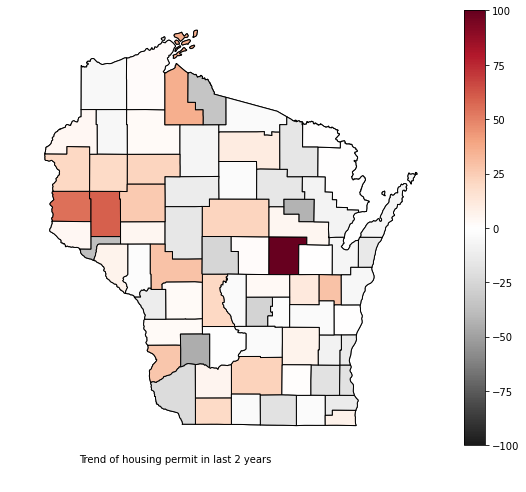

In [16]:
fig, gax = plt.subplots(figsize = (10,8))

# Plot the state
county_wisconsin_df.plot(ax = gax, edgecolor='black',color='white')

# Plot the counties and pass 'rel_trump_share' as the data to color
gdf1.plot( vmin=-100, vmax=100,
    ax=gax, edgecolor='black', column='DeltaHouses_2y', legend=True, cmap='RdGy_r'
)



# Add text to let people know what we are plotting
gax.annotate('Trend of housing permit in last 2 years',xy=(0.15, 0.06),  xycoords='figure fraction')

# I don't want the axis with long and lat
plt.axis('off')

plt.show()

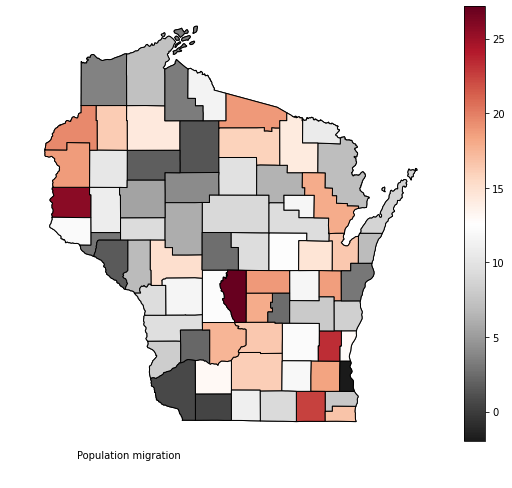

In [17]:
fig, gax = plt.subplots(figsize = (10,8))

# Plot the state
county_wisconsin_df.plot(ax = gax, edgecolor='black',color='white')

# Plot the counties and pass 'rel_trump_share' as the data to color
gdf1.plot(ax=gax, edgecolor='black', column='delta_population', legend=True, cmap='RdGy_r'
)



# Add text to let people know what we are plotting
gax.annotate('Population migration',xy=(0.15, 0.06),  xycoords='figure fraction')

# I don't want the axis with long and lat
plt.axis('off')

plt.show()

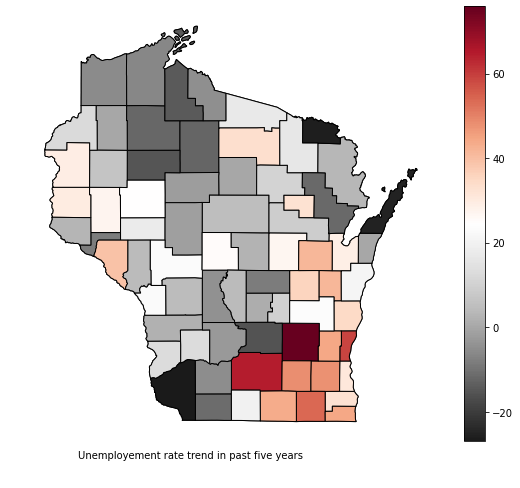

In [18]:
fig, gax = plt.subplots(figsize = (10,8))

# Plot the state
county_wisconsin_df.plot(ax = gax, edgecolor='black',color='white')

# Plot the counties and pass 'rel_trump_share' as the data to color
gdf1.plot(ax=gax, edgecolor='black', column='delta_rate', legend=True, cmap='RdGy_r'
)



# Add text to let people know what we are plotting
gax.annotate('Unemployement rate trend in past five years',xy=(0.15, 0.06),  xycoords='figure fraction')

# I don't want the axis with long and lat
plt.axis('off')

plt.show()

In [19]:
# Notice how the population ran away from Milwakee, perhaps because the unemployement rates had increased (?)
# Now this shapefile needs to be spatially joined with the one provided in the tabular_data folder by BAIN
# Two shapefiles can be spatially joined only if they have the same crs

shapefile = gpd.read_file('20201020_tabular_data/tiles.shp')
shapefile = shapefile.to_crs(epsg=4269)
gdf1 = gdf1.to_crs(epsg=4269)

joined_shape = gpd.sjoin(shapefile, gdf1, how='inner',op='within')
df_first = pd.DataFrame(joined_shape)

In [20]:
# the dataframe does not need the geometry anymore
df_first.drop(columns=['geometry','index_right'], inplace=True)
# and now it can be finally merged with the analytical_table.csv with the tiles
data_df = pd.read_csv('20201020_tabular_data/analytical_table.csv')
df_part1 = pd.merge(data_df,df_first, how='left', on=['tile_h','tile_v'])

# for sizing of pictures later:
figsize_x = 10
figsize_y = (data_df["tile_h"].max())/(data_df["tile_v"].max()) * 10

In [21]:
"""
PLOTTING: We have added the counties information to our final dataframe
"""

'\nPLOTTING: We have added the counties information to our final dataframe\n'

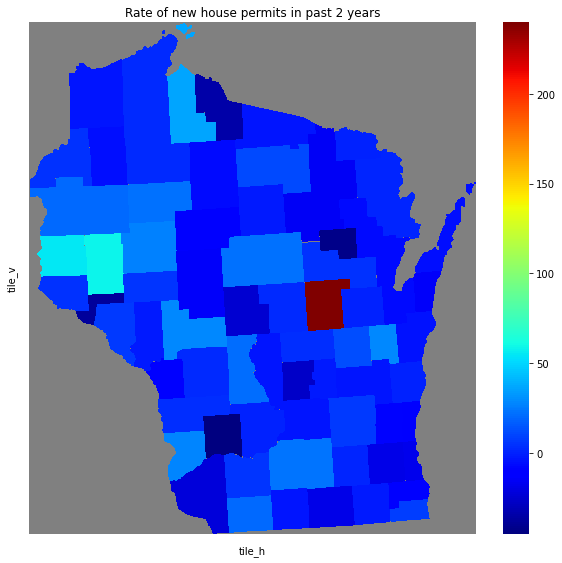

In [22]:
pivotted = df_part1.pivot('tile_v','tile_h','DeltaHouses_2y')
import seaborn as sns
plt.figure(figsize=(figsize_x,figsize_y))
urban_map = sns.heatmap(pivotted, cmap = "jet")
urban_map.set_title("Rate of new house permits in past 2 years")
urban_map.tick_params(left=False, bottom= False)
urban_map.set(xticklabels=[], yticklabels=[])
urban_map.set_facecolor("grey")

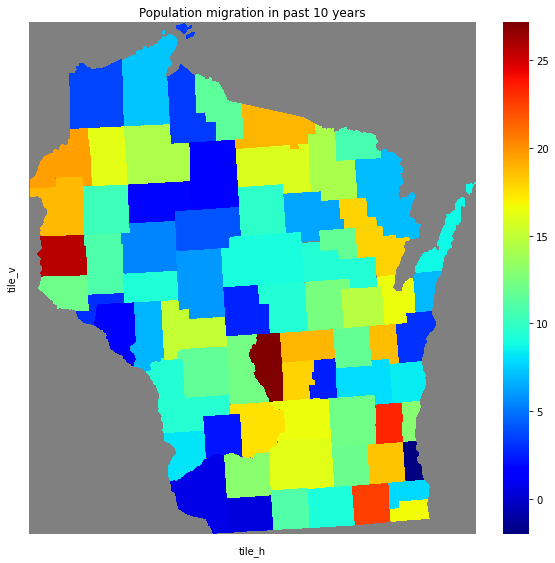

In [23]:
pivotted = df_part1.pivot('tile_v','tile_h','delta_population')
import seaborn as sns
plt.figure(figsize=(figsize_x,figsize_y))
urban_map = sns.heatmap(pivotted, cmap = "jet")
urban_map.set_title("Population migration in past 10 years")
urban_map.tick_params(left=False, bottom= False)
urban_map.set(xticklabels=[], yticklabels=[])
urban_map.set_facecolor("grey")

In [24]:
"""
PART 3: Walmart locations 
"""

'\nPART 3: Walmart locations \n'

In [25]:
# I found data for store openings of Walmart here: http://users.econ.umn.edu/~holmes/data/WalMart/index.html

stores = pd.read_csv('tabular_data/store_openings.csv')
stores_wi = stores[stores['STRSTATE']=='WI']

# In this case I'll be needing geopy geocoders because we are dealing with point coordinates:
from geopy.geocoders import Nominatim
locator = Nominatim(user_agent="myGeocoder")

#create new column with entire location address that can be used by geocode
stores_wi['Location'] = stores_wi['STREETADDR'] + ', ' + stores_wi['STRCITY'] + ', Wisconsin, US'
#add information on whether it is a SUPERSTORE or a plain walmart store
stores_wi['type'] = ''
stores_wi['type'] = stores_wi['type_store'] == 'Wal-Mart'
stores_wi['type'] = stores_wi['type'].astype(int)
stores_wi['type'] = stores_wi['type'] + 1

stores_wi.drop(columns=['storenum', 'date_super', 'conversion', 'st', 'county',
       'STREETADDR', 'STRCITY', 'STRSTATE', 'ZIPCODE', 'type_store'], inplace = True)
stores_wi.reset_index(drop=True, inplace=True)
#Only first 60 were built before 2001
store_wi = stores_wi.head(60)

<ipython-input-25-8dd36bcdb94a>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stores_wi['Location'] = stores_wi['STREETADDR'] + ', ' + stores_wi['STRCITY'] + ', Wisconsin, US'
<ipython-input-25-8dd36bcdb94a>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stores_wi['type'] = ''
<ipython-input-25-8dd36bcdb94a>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http

In [26]:
store_wi.drop(columns='OPENDATE', inplace=True)
# The stores are sorte by date, so I wanted to give a value for a store's age, this way we will know where the newest store
# was built
store_wi.reset_index(drop=False, inplace=True)
store_wi.rename(columns={'index':'age'}, inplace=True)
# I basically used the index and added a one, so that the newest store has age=1
store_wi['age'] = store_wi['age'] + 1

C:\Users\Stefano\anaconda3\envs\geo-env\lib\site-packages\pandas\core\frame.py:4296: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(
<ipython-input-26-a0d396663e47>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  store_wi['age'] = store_wi['age'] + 1


In [27]:
# # # LOCATION:

# With geocode I create a column named loc that has the whole geographical localisation
store_wi["loc"] = store_wi["Location"].apply(locator.geocode)
# Need the points
store_wi["point"] = store_wi["loc"].apply(lambda loc: tuple(loc.point) if loc else None)
# Same with latituted, longitude and altitude
store_wi[['lat', 'lon', 'altitude']] = pd.DataFrame(store_wi['point'].to_list(), index=store_wi.index)
# create a geodataframe out of it
gdf2 = gpd.GeoDataFrame(store_wi, geometry=gpd.points_from_xy(store_wi.lon,store_wi.lat))
gdf2 = gdf2.set_crs(epsg=4269)

<ipython-input-27-e87b7aeadf6a>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  store_wi["loc"] = store_wi["Location"].apply(locator.geocode)
<ipython-input-27-e87b7aeadf6a>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  store_wi["point"] = store_wi["loc"].apply(lambda loc: tuple(loc.point) if loc else None)
C:\Users\Stefano\anaconda3\envs\geo-env\lib\site-packages\pandas\core\frame.py:3065: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_ind

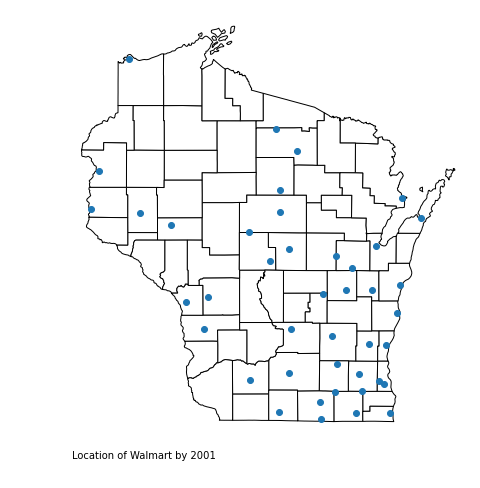

In [28]:
# PLOTTING 
county_df = gpd.read_file('zip://cb_2016_us_county_5m.zip')
county_wisconsin_df = county_df.query("STATEFP == '55'")

fig, gax = plt.subplots(figsize = (10,8))

# Plot the state
county_wisconsin_df.plot(ax = gax, edgecolor='black',color='white')

# Plot the location of walmarts 
gdf2.plot(ax=gax)

# Add text to let people know what we are plotting
gax.annotate('Location of Walmart by 2001',xy=(0.15, 0.06),  xycoords='figure fraction')

# I don't want the axis with long and lat
plt.axis('off')

plt.show()

In [29]:
# COMBINING WITH SHAPEFILE, LIKE I DID BEFORE
gdf2.drop(columns=['Location', 'loc', 'point', 'lat', 'lon',
       'altitude'], inplace=True)

# We have already set the crs of gdf2 and the shapefile was already introduced
walmart_shape = gpd.sjoin(gdf2, shapefile, how='inner',op='within')
df_second = pd.DataFrame(walmart_shape)

df_final = pd.merge(df_part1,df_second, how='left', on=['tile_h','tile_v'])

In [30]:
df_final.rename(columns={'age':'store_age','type':'store_type'}, inplace=True)
df_final.drop(columns=['geometry', 'index_right'], inplace=True)

In [31]:
df_final.to_csv('analytical_data_withadditions.csv', sep=';', encoding='utf-8')

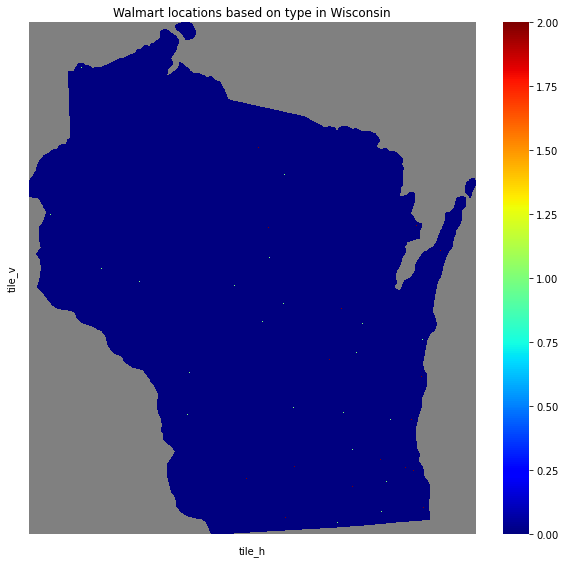

In [32]:
"""This is only for plotting, won't be saved in the final csv file"""
df_final['store_age'] = df_final['store_age'].fillna(0)
df_final['store_type'] = df_final['store_type'].fillna(0)

pivotted = df_final.pivot('tile_v','tile_h','store_type')
import seaborn as sns
plt.figure(figsize=(figsize_x,figsize_y))
urban_map = sns.heatmap(pivotted, cmap = "jet")
urban_map.set_title("Walmart locations based on type in Wisconsin")
urban_map.tick_params(left=False, bottom= False)
urban_map.set(xticklabels=[], yticklabels=[])
urban_map.set_facecolor("grey")

NameError: name 'df_final' is not defined